# Classifying Toxicity - bi-LSTMs and 2D Convs - Dec 21st

    - 200D Glove embeddings and 30 max sequence length

### Load Libraries and Data Sets

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

import re

import string     # Imports the library
import nltk        # Imports the natural language toolkit
from nltk.corpus import stopwords

#nltk.download('stopwords')   # Download the stopwords dataset
#nltk.download('wordnet')

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
#tfds.list_builders()

In [3]:

#df_train_wiki_tox = pd.read_csv("../input/jigsaw-toxic-comment-classification-challenge/train.csv")
df_train_wiki_tox = pd.read_csv("train.csv")

### Load Pre-trained Glove and Word2Vec embeddings

In [3]:
import numpy as np # linear algebra
import os, sys

from gensim.models import Word2Vec, KeyedVectors
from gensim.test.utils import datapath

C:\Users\Rober\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
np.__version__

'1.21.4'

In [6]:
# import gensim.downloader as api
# info_df = pd.DataFrame.from_dict(api.info()['models'], orient='index')
# info_df[['file_size', 'base_dataset', 'parameters']]

In [7]:
#model=api.load("fasttext-wiki-news-subwords-300")
#model=api.load("glove-twitter-200")
#model=api.load("glove-wiki-gigaword-300")

In [8]:
import time
t_start = time.time()


# Get path to file
vector_size = 200

glove_file = 'glove.twitter.27B.200d_wv.txt'


# Load with gensim
model = KeyedVectors.load_word2vec_format(glove_file)
#model = KeyedVectors.load(glove_file)

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 90.441 seconds


### EDA and Comment Text Cleansing

In [9]:
def text_process_1(text):
    #text=text.decode('utf-8')
    
    # Replace the xa0 with a space
    text=text.replace('xa0',' ')
    # Replace the \xa0 with a space
    text=text.replace('\xa0',' ')
    # Replace the \n\n with a space
    text=text.replace('\n\n',' ')
    # Replace the \n with a space
    text=text.replace('\n',' ')
    # Replace apostrophes with nothing
    text=text.replace('\'','')
    # Replace http with a space
    text=text.replace('http','')
    
    # Replace hyphens with a space
    text=text.replace('-','')
    
    tokens = nltk.word_tokenize(text)
    
    cleaned_words=[w.lower() for w in tokens if w.isalnum()]
    #remove any words that are actually digits. 
    no_integers = [x for x in cleaned_words if not (x.isdigit() or x[0] == '-' and x[1:].isdigit())]
    
    
    # The code for removing stopwords
    stoplist = stopwords.words('english') 
    stoplist = set(stoplist)
    
    No_StopWords = [word for word in no_integers if word.lower() not in stoplist ]
    
    No_StopWords = ' '.join(No_StopWords)
    
    return No_StopWords

In [10]:
import time
t_start = time.time()

df_train_wiki_tox['clean']=df_train_wiki_tox['comment_text'].apply(lambda x: text_process_1(x))


t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 88.756 seconds


In [11]:
df_train_wiki_tox.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww matches background colour im seemingly st...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really trying edit war guy constant...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,cant make real suggestions improvement wondere...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page thats


In [12]:
df_train_wiki_tox.shape[0]

159571

In [13]:
df_train_wiki_tox['clean'][1]

'daww matches background colour im seemingly stuck thanks talk january utc'

In [14]:
import random
random.randint(1,df_train_wiki_tox.shape[0])

153968

##### Print 10 Random Non-Toxic Comments

In [15]:
# df_non_tox = df_train_wiki_tox[df_train_wiki_tox['toxic']==0]
# df_non_tox = df_non_tox.reset_index()


# for i in range(10):
    
#     n=random.randint(1,df_non_tox.shape[0])
#     print(n)
#     orig_cmt = df_non_tox['comment_text'][n]
#     rnd_cmt = df_non_tox['clean'][n]
#     print(rnd_cmt)
#     print('...')
#     print(orig_cmt)
#     print('\n')

In [16]:
df_toxic = df_train_wiki_tox[df_train_wiki_tox['toxic']==1]

In [17]:
df_toxic['comment_text'][6]

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

##### Print 10 Random Toxic Comments

In [18]:
# df_tox = df_train_wiki_tox[df_train_wiki_tox['toxic']==1]
# df_tox = df_tox.reset_index()


# for i in range(10):
    
#     n=random.randint(1,df_tox.shape[0])
#     print(n)
#     orig_cmt = df_tox['comment_text'][n]
#     rnd_cmt = df_tox['clean'][n]
#     print(rnd_cmt)
#     print('...')
#     print(orig_cmt)
#     print('\n')

#### Create Final Training Data set of comments greater than 5 words and less than 300 words

In [19]:
import time
t_start = time.time()

df_train_wiki_tox['wd_len']=df_train_wiki_tox['clean'].apply(lambda x: len(nltk.word_tokenize(x)))



t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 20.094 seconds


In [20]:
df_small = df_train_wiki_tox[(df_train_wiki_tox['wd_len']<30) & (df_train_wiki_tox['wd_len']>=1)]
df_small=df_small.reset_index()
df_small.pop('index')
df_small['severe_toxic'].value_counts()

0    106708
1      1290
Name: severe_toxic, dtype: int64

In [21]:
from sklearn import preprocessing
# instatiate sklearn's labelencoder
le = preprocessing.LabelEncoder()

# fit label encorder and return encoded integer labels for categorical string features
df_small['new_severe_toxic'] = le.fit_transform(df_small['severe_toxic'].values)
df_small['new_severe_toxic'].value_counts()
#df_3.pop('Results')



0    106708
1      1290
Name: new_severe_toxic, dtype: int64

In [22]:
# fit label encorder and return encoded integer labels for categorical string features
df_small['new_toxic'] = le.fit_transform(df_small['toxic'].values)
df_small['new_toxic'].value_counts()
#df_3.pop('Results')

0    95803
1    12195
Name: new_toxic, dtype: int64

#### Look at those toxic comments with less than 5 words

In [23]:
df_train_wiki_tox[(df_train_wiki_tox['wd_len']<=4) & (df_train_wiki_tox['toxic']==1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,wd_len
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,cocksucker piss around work,4
211,0086998b34865f93,"Fuck you, block me, you faggot pussy!",1,0,1,0,1,0,fuck block faggot pussy,4
268,00ab65775c601cf9,Atheism is full of bias shit,1,0,0,0,0,0,atheism full bias shit,4
423,01113aece2e95a73,Be careful who you call a moron.,1,0,0,0,0,0,careful call moron,3
442,01208d2b76624130,Hi \n\nIm a fucking bitch.\n\n50.180.208.181,1,1,1,0,1,0,hi im fucking bitch,4
...,...,...,...,...,...,...,...,...,...,...
159394,fcf5a6ad5918f164,your boring \n\nand retarded two,1,0,0,0,0,0,boring retarded two,3
159448,fdc92e571d39e7e1,Yeah i no it sucks.,1,0,0,0,0,0,yeah sucks,2
159449,fdce660ddcd6d7ca,I think he is a gay fag!!!,1,0,0,0,0,1,think gay fag,3
159493,fef142420a215b90,FUCKING FAGGOT \n\nLOLWAT.,1,0,1,0,1,0,fucking faggot lolwat,3


#### Distribution plot of word Lengths by Toxicity Label

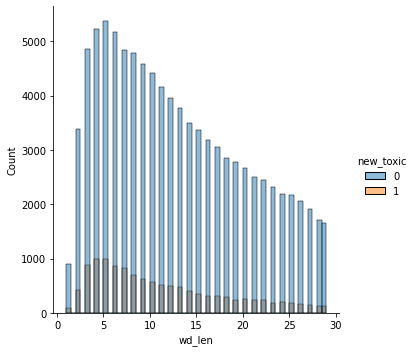

In [24]:
import seaborn as sns

sns.displot(df_small, x="wd_len", hue="new_toxic")

### First check to see if the words in the sentence also exist in the Glove Model
    - replace any words not found in Glove with 'bland'

In [25]:
def word_replacer(sent):
    sent_list = [x if x in model.key_to_index else 'bland' for x in sent.split(' ')] 
    sentence = ' '.join(sent_list)
    return sentence

In [26]:
cc='asdfsadfasdfs'
word_replacer(cc)

'bland'

In [27]:
import time
t_start = time.time()

df_small['clean_w2v']=df_small['clean'].apply(lambda x: word_replacer(x))

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 0.311 seconds


#### For sentences less than 70 words, padd the input by repeating words until length of 70 is reached 

In [28]:
def sentence_padder(a):
    b=a.split(' ')
    c=b
    seq_len=31
    missing_len_idx = seq_len-len(b)-1

    for m in range(missing_len_idx):
        c.append(b[m])
        
    d = ' '.join(c)
    return d

In [29]:
df_small['clean_w2v'][666]

'real vagina real photo vagina gone would mind make new one vagina picture indonesians vagina love'

In [30]:
sentence_padder(df_small['clean_w2v'][666])

'real vagina real photo vagina gone would mind make new one vagina picture indonesians vagina love real vagina real photo vagina gone would mind make new one vagina picture indonesians'

In [31]:
import time
t_start = time.time()

df_small['clean_w2v_padding']=df_small['clean_w2v'].apply(lambda x: sentence_padder(x))

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 0.232 seconds


#### Check word lengths of padded sentences

In [32]:
import time
t_start = time.time()

df_small['w2v_padding_wd_len']=df_small['clean_w2v_padding'].apply(lambda x: len(nltk.word_tokenize(x)))

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 11.426 seconds


In [33]:
df_small['w2v_padding_wd_len'].value_counts()

30    107998
Name: w2v_padding_wd_len, dtype: int64

#### For sentences greater than 30 words, truncate the input so its only 70 words

In [34]:
def sentence_shortener(testt):
    testt2=testt.split(' ')
    testt3=testt2[0:30]
    testt4 = ' '.join(testt3)
    return testt4

In [35]:
import time
t_start = time.time()

df_small['clean_w2v_padding_2']=df_small['clean_w2v_padding'].apply(lambda x: sentence_shortener(x))

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 0.176 seconds


#### Check word lengths of truncated sentences

In [36]:
import time
t_start = time.time()

df_small['w2v_padding_wd_len_2']=df_small['clean_w2v_padding_2'].apply(lambda x: len(nltk.word_tokenize(x)))

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 11.493 seconds


In [37]:
df_small['w2v_padding_wd_len_2'].value_counts()

30    107998
Name: w2v_padding_wd_len_2, dtype: int64

#### Toxic Comments Classification - Under Sample Majority Class 

In [38]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler
# define undersample strategy
undersample = RandomUnderSampler(.5)

#undersample_2 = RandomUnderSampler(sampling_strategy='majority')

C:\Users\Rober\anaconda3\lib\site-packages\imblearn\utils\_validation.py:587: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [39]:
#https://stackoverflow.com/questions/53723928/attributeerror-series-object-has-no-attribute-reshape
X=df_small['clean_w2v_padding_2']
X=X.values.reshape(-1, 1)

Y=df_small['new_toxic']
Y=Y.values.reshape(-1, 1)

X_under, y_under = undersample.fit_resample(X, Y)
new_x=pd.DataFrame(X_under)[0]
new_y=pd.DataFrame(y_under)[0]

#### Severely Toxic Comments Classification - Under Sample Majority Class 

In [40]:
# X_2=df_small['clean_w2v_padding_2']
# X_2=X_2.values.reshape(-1, 1)

# Y_2=df_small['new_severe_toxic']
# Y_2=Y_2.values.reshape(-1, 1)

# X_under_2, y_under_2 = undersample_2.fit_resample(X_2, Y_2)
# new_x_2=pd.DataFrame(X_under_2)[0]
# new_y_2=pd.DataFrame(y_under_2)[0]

### Attempt to create Sentence Tensors

#### Create 30-dim Sentence Vector for each comment by looking up word in Word2vec

In [41]:
#convert each token in sentence into a 768 Glove Vector
def sent_vectorizer_1(text):
    sent_vector = [model[x] for x in text.split(' ') if x in model.key_to_index] 
    return sent_vector

In [64]:
len(new_x)

36585

In [65]:
new_x[1]

'defamation dont know bland bland habitual liar lie documented many places example defamation dont know bland bland habitual liar lie documented many places example defamation dont know bland bland habitual'

In [66]:
new_x[2]

'gave permission insult religious organisation using wikipedia source gave permission insult religious organisation using wikipedia source gave permission insult religious organisation using wikipedia source gave permission insult religious organisation using'

In [67]:
sdx=new_x[5]
sent_tensor=sent_vectorizer_1(sdx)
len(sent_tensor)

30

In [68]:
len(sent_tensor[0])

200

### Sentence Tensor - Toxic Comments

In [69]:
import time
t_start = time.time()

tox_sentences_traindata = []
for i in range(len(new_x)):
    tox_sentences_traindata.append(sent_vectorizer_1(new_x[i]))
#traindata = tf.convert_to_tensor(traindata)

t_stop = time.time()
print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

Time elapsed: 1.271 seconds


In [70]:
tox_tensor_sentences_traindata = tf.convert_to_tensor(tox_sentences_traindata)

In [71]:
new_y

0        0
1        0
2        0
3        0
4        0
        ..
36580    1
36581    1
36582    1
36583    1
36584    1
Name: 0, Length: 36585, dtype: int64

### Sentence Vector - Severley Toxic Comments

In [50]:
# import time
# t_start = time.time()

# sev_tox_sentences_traindata = []
# for i in range(len(new_x_2)):
#     sev_tox_sentences_traindata.append(sent_vectorizer_1(new_x_2[i]))
# #traindata = tf.convert_to_tensor(traindata)

# t_stop = time.time()
# print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

In [51]:
# sev_tox_tensor_sentences_traindata = tf.convert_to_tensor(sev_tox_sentences_traindata)

In [52]:
# new_y_2

#### Training Tensor and Y labels

In [72]:
tox_tensor_sentences_traindata.shape

TensorShape([36585, 30, 200])

In [73]:
#sev_tox_tensor_sentences_traindata.shape

In [74]:
tox_tensor_y_labels = tf.convert_to_tensor(new_y)
#sev_tox_tensor_y_labels = tf.convert_to_tensor(new_y_2)

In [75]:
tox_tensor_y_labels.shape

TensorShape([36585])

In [76]:
#sev_tox_tensor_y_labels.shape

# Build Deep Learning Models

#### import necessary tools and models 

In [4]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import keras
import tensorflow

import tensorflow.keras
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy as np

from keras.layers.convolutional import Conv1D, MaxPooling1D


import keras.utils
from keras import utils as np_utils

from keras.utils import np_utils


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers import SpatialDropout1D, MaxPooling1D, Bidirectional, GRU, concatenate


# import necessary tools and models 
import seaborn as sns
import matplotlib.pyplot as plt 

import sklearn.model_selection as cv
from sklearn.model_selection import cross_val_score
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from keras.regularizers import l2, l1_l2

#### Train Test split for Tensors

In [78]:
#https://stackoverflow.com/questions/41859605/split-tensor-into-training-and-test-sets

def train_test_split_tensors(X, y, **options):
    """
    encapsulation for the sklearn.model_selection.train_test_split function
    in order to split tensors objects and return tensors as output

    :param X: tensorflow.Tensor object
    :param y: tensorflow.Tensor object
    :dict **options: typical sklearn options are available, such as test_size and train_size
    """

    from sklearn.model_selection import train_test_split

    X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y.numpy(), **options)

    X_train, X_test = tf.constant(X_train), tf.constant(X_test)
    y_train, y_test = tf.constant(y_train), tf.constant(y_test)

    del(train_test_split)

    return X_train, X_test, y_train, y_test

In [79]:
# Regular Toxic - separate train - test data
X_train, X_test, y_train, y_test = train_test_split_tensors(tox_tensor_sentences_traindata, 
                                                            tox_tensor_y_labels, test_size=.3, random_state=69)

# # Severely Toxic - separate train - test data 
# sv_X_train, sv_X_test, sv_y_train, sv_y_test = train_test_split_tensors(sev_tox_tensor_sentences_traindata, 
#                                                             sev_tox_tensor_y_labels, test_size=.3, random_state=69)

#### Pickle the Test Tensors

In [106]:
import pickle

In [107]:
filename = 'tox_x_test'
outfile = open(filename,'wb')
pickle.dump(X_test,outfile)
outfile.close()

In [108]:
filename = 'tox_y_test'
outfile = open(filename,'wb')
pickle.dump(y_test,outfile)
outfile.close()

#### Delete original Tensors prior to Train / Test Split

In [80]:
del tox_tensor_y_labels

In [81]:
del tox_tensor_sentences_traindata

#### Dropout() layer possibly drops time steps too

https://stackoverflow.com/questions/50720670/using-dropout-with-keras-and-lstm-gru-cell

https://stackoverflow.com/questions/49940280/keras-lstm-dropout-vs-recurrent-dropout

#### Use Recurrent Regularizer

https://stackoverflow.com/questions/53656220/how-to-add-recurrent-dropout-to-cudnngru-or-cudnnlstm-in-keras

https://stackoverflow.com/questions/61931629/overfitting-in-lstm-even-after-using-regularizers

#### Compile and Train Model for Regular Toxicity 

In [82]:
# Fit model
epochs = 200
batch_size=32
#early_stopping_monitor = EarlyStopping(patience=10)

In [83]:
X_train.shape

TensorShape([25609, 30, 200])

In [84]:
# create and fit the LSTM network
DL_model = Sequential()
DL_model.add(SpatialDropout1D(0.2))

# DL_model.add((LSTM(128, return_sequences=True, kernel_regularizer=l2(0.00021), 
#                                 recurrent_regularizer=l2(0.00021), input_shape=(70,200))))
DL_model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.00021), 
                                recurrent_regularizer=l2(0.00021), input_shape=(30,200))))
DL_model.add(Dropout(0.2))

#Conv2D needs 4 dims - batch size, width, height, and number of channels
#DL_model.add(Conv2D(128, 5, 2, activation = 'relu', kernel_initializer = 'he_uniform'))

DL_model.add(tf.keras.layers.Reshape((30, 256, 1), input_shape=(30, 256)))

DL_model.add(Conv2D(filters=128, 
                       kernel_size=(5,2), 
                       input_shape=(30, 256, 1), 
                       activation="relu"))

# DL_model.add(MaxPooling1D(2))
DL_model.add(Dropout(.2))
DL_model.add(Flatten())
#DL_model.add(BatchNormalization())


DL_model.add(Dense(256, activation="relu"))
DL_model.add(Dropout(.4))
DL_model.add(Dense(128, activation="relu"))
DL_model.add(Dropout(.4))
DL_model.add(Dense(10, activation="relu"))
DL_model.add(Dropout(.4))
DL_model.add(Dense(1, activation="sigmoid"))

In [ ]:
#DL_model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])
DL_model.summary()

In [85]:
DL_model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=tensorflow.keras.optimizers.Adam(),
              metrics=['accuracy'])


In [86]:
#DL_model.summary()

##### Train bi-LSTM and 2D Conv Model

In [87]:
my_callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0, patience=5),
    ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.4f}.h5'),
    TensorBoard(log_dir='logs'),
]

In [88]:
history = DL_model.fit(X_train, y_train, 
                       epochs=100, batch_size=32,
                       validation_split=0.2, callbacks=my_callbacks,
                      )

Epoch 1/100
641/641 [==============================] - 51s 50ms/step - loss: 0.4534 - accuracy: 0.8480 - val_loss: 0.3061 - val_accuracy: 0.9157
Epoch 2/100
641/641 [==============================] - 31s 48ms/step - loss: 0.3035 - accuracy: 0.9034 - val_loss: 0.2766 - val_accuracy: 0.9162
Epoch 3/100
641/641 [==============================] - 31s 48ms/step - loss: 0.2749 - accuracy: 0.9094 - val_loss: 0.2637 - val_accuracy: 0.9147
Epoch 4/100
641/641 [==============================] - 31s 48ms/step - loss: 0.2597 - accuracy: 0.9150 - val_loss: 0.2422 - val_accuracy: 0.9194
Epoch 5/100
641/641 [==============================] - 31s 48ms/step - loss: 0.2527 - accuracy: 0.9163 - val_loss: 0.2633 - val_accuracy: 0.9174
Epoch 6/100
641/641 [==============================] - 31s 48ms/step - loss: 0.2444 - accuracy: 0.9202 - val_loss: 0.2495 - val_accuracy: 0.9196
Epoch 7/100
641/641 [==============================] - 31s 48ms/step - loss: 0.2383 - accuracy: 0.9273 - val_loss: 0.2591 - val_ac

#### Load Best Model Back In and evaluate against Test Set

In [5]:
import pickle

In [6]:
filename = 'tox_x_test'
infile = open(filename,'rb')
X_test = pickle.load(infile)
infile.close()

In [7]:
filename = 'tox_y_test'
infile = open(filename,'rb')
y_test = pickle.load(infile)
infile.close()

In [8]:
#testing - to free GPU Memory - kernel must be restarted after loading each new Model 

#DL_model = keras.models.load_model('model.06-0.2495.h5')
# 343/343 [==============================] - 7s 9ms/step - loss: 0.2434 - accuracy: 0.9193
# Test result: 91.928 loss: 0.243
DL_model = keras.models.load_model('model.04-0.2422.h5')

# 343/343 [==============================] - 6s 9ms/step - loss: 0.2370 - accuracy: 0.9206
# Test result: 92.065 loss: 0.237

scores = DL_model.evaluate(X_test, y_test, batch_size=32, verbose=1)
print('Test result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

343/343 [==============================] - 6s 9ms/step - loss: 0.2370 - accuracy: 0.9206
Test result: 92.065 loss: 0.237


### Plot the loss curve

In [ ]:
plt.figure(221)

plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 51, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
 
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 51, 2.0))
plt.rcParams['figure.figsize'] = (12, 4)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])
 
plt.show()

### Compile and Train Model for Severe Toxicity 
    
    - Severe Toxicity more explicit to identify, probably don't need LSTM models to identify

In [ ]:
# #Fit model
# epochs_2 = 200
# batch_size_2 =32
# early_stopping_monitor_2 = EarlyStopping(patience=300)

In [ ]:
# sv_X_train.shape

In [ ]:
# # create and fit the LSTM network
# DL_model_2 = Sequential()
# DL_model_2.add(SpatialDropout1D(0.2))
# #DL_model_2.add(Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout(.3),kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), input_shape=(100,512))))
# DL_model_2.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.00021), recurrent_regularizer=l2(0.00021), input_shape=(100,300))))
# DL_model_2.add(SpatialDropout1D(0.3))

# DL_model_2.add(Conv1D(128, 5, 2, activation = 'relu', kernel_initializer = 'he_uniform'))

# DL_model_2.add(MaxPooling1D(2))
# DL_model_2.add(Dropout(.3))
# DL_model_2.add(Flatten())
# DL_model_2.add(BatchNormalization())


# DL_model_2.add(Dense(256, activation="relu"))
# DL_model_2.add(Dropout(.4))
# DL_model_2.add(Dense(128, activation="relu"))
# DL_model_2.add(Dropout(.4))
# DL_model_2.add(Dense(10, activation="relu"))
# DL_model_2.add(Dropout(.4))
# DL_model_2.add(Dense(1, activation="sigmoid"))

In [ ]:
# DL_model_2.compile(loss=keras.losses.binary_crossentropy,
#               optimizer=tensorflow.keras.optimizers.Adam(),
#               metrics=['accuracy'])

In [ ]:
# DL_model_2.summary()

In [ ]:
# my_callbacks_2 = [
#     EarlyStopping(monitor='val_loss', min_delta=0, patience=5),
#     ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
#     TensorBoard(log_dir='logs'),
# ]

In [ ]:
# # #train model
# history_2 = DL_model_2.fit(sv_X_train, sv_y_train, 
#                        epochs=100, batch_size=32,
#                        validation_split=0.2, callbacks=my_callbacks_2,
#                        workers=14,
#                        use_multiprocessing=True
#                       )

In [ ]:
# # #testing
# scores_2 = DL_model_2.evaluate(sv_X_test, sv_y_test, batch_size=32, verbose=1)
# print('Test result: %.3f loss: %.3f' % (scores_2[1]*100,scores_2[0]))

In [ ]:
# #save model to disk
# model_json = DL_model_2.to_json()
# with open('model_ann_severe_toxic.json', 'w') as json_file:
#     json_file.write(model_json)
# DL_model_2.save_weights('model_ann_severe_toxic.h5') 

In [ ]:
# plt.figure(221)

# plt.figure(0)
# plt.plot(history_2.history['accuracy'],'r')
# plt.plot(history_2.history['val_accuracy'],'g')
# plt.xticks(np.arange(0, 101, 2.0))
# plt.rcParams['figure.figsize'] = (12, 4)
# plt.xlabel("Num of Epochs")
# plt.ylabel("Accuracy")
# plt.title("Training Accuracy vs Validation Accuracy")
# plt.legend(['train','validation'])
 
 
# #plt.figure(1)
# plt.plot(history_2.history['loss'],'r')
# plt.plot(history_2.history['val_loss'],'g')
# plt.xticks(np.arange(0, 101, 2.0))
# plt.rcParams['figure.figsize'] = (12, 4)
# plt.xlabel("Num of Epochs")
# plt.ylabel("Loss")
# plt.title("Training Loss vs Validation Loss")
# plt.legend(['train','validation'])
 
# plt.show()

# Submission Data Set

In [ ]:
# df_test = pd.read_csv('../input/jigsaw-toxic-severity-rating/comments_to_score.csv',low_memory = False) 

In [ ]:
# import time
# t_start = time.time()

# df_test['clean']=df_test['text'].apply(lambda x: text_process_1(x))


# t_stop = time.time()
# print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

In [ ]:
# import time
# t_start = time.time()
# df_test['clean_w2v']=df_test['clean'].apply(lambda x: word_replacer(x))
# df_test['clean_w2v_padding']=df_test['clean_w2v'].apply(lambda x: sentence_padder(x))
# df_test['clean_w2v']=df_test['clean'].apply(lambda x: word_replacer(x))
# df_test['w2v_padding_wd_len']=df_test['clean_w2v_padding'].apply(lambda x: len(nltk.word_tokenize(x)))

# df_test['clean_w2v_padding_2']=df_test['clean_w2v_padding'].apply(lambda x: sentence_shortener(x))
# df_test['w2v_padding_wd_len_2']=df_test['clean_w2v_padding_2'].apply(lambda x: len(nltk.word_tokenize(x)))

# t_stop = time.time()
# print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

In [ ]:
# import time
# t_start = time.time()

# sentences_test = []
# for i in range(len(pd.Series(df_test['clean_w2v_padding_2']))):
#     sentences_test.append(sent_vectorizer_1(pd.Series(df_test['clean_w2v_padding_2'])[i]))
# #traindata = tf.convert_to_tensor(traindata)

# t_stop = time.time()
# print('Time elapsed: {:.3f} seconds'.format(t_stop - t_start))

In [ ]:
# tensor_sentences_traindata = tf.convert_to_tensor(sentences_test)

In [ ]:
# test_ids=df_test['comment_id']
# tensor_y_test = tf.convert_to_tensor(test_ids)

#### Predict Severe Toxicity

In [ ]:
# Y_test_pred_Sev_tox=DL_model_2.predict(tensor_sentences_traindata)
# Y_test_pred_Sev_tox_2=pd.DataFrame(Y_test_pred_Sev_tox)
# Y_test_pred_Sev_tox_2

#### Predict Regular Toxicity

In [ ]:
Y_test_pred_reg_tox=DL_model.predict(tensor_sentences_traindata)
Y_test_pred_reg_tox_2=pd.DataFrame(Y_test_pred_reg_tox)
Y_test_pred_reg_tox_2

#### Add Regular and Severe Toxicity together for final ranking score

In [ ]:
# df_merge=pd.concat([test_ids, Y_test_pred_reg_tox_2, Y_test_pred_Sev_tox_2], axis=1)
# df_merge.columns=["comment_id","b","d"]

# df_merge['score']=df_merge['b']+df_merge['d']
# df_merge.pop('b')
# df_merge.pop('d')
# df_merge

In [ ]:
# df_merge=pd.concat([test_ids, Y_test_pred_reg_tox_2], axis=1)
# df_merge.columns=["comment_id","b"]

# df_merge['score']=df_merge['b']
# df_merge.pop('b')
# #df_merge.pop('d')
# df_merge

In [ ]:
#df_merge.to_csv('submission.csv', index=False)